In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import backend as K

from sklearn.manifold import TSNE

#**Load data**

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


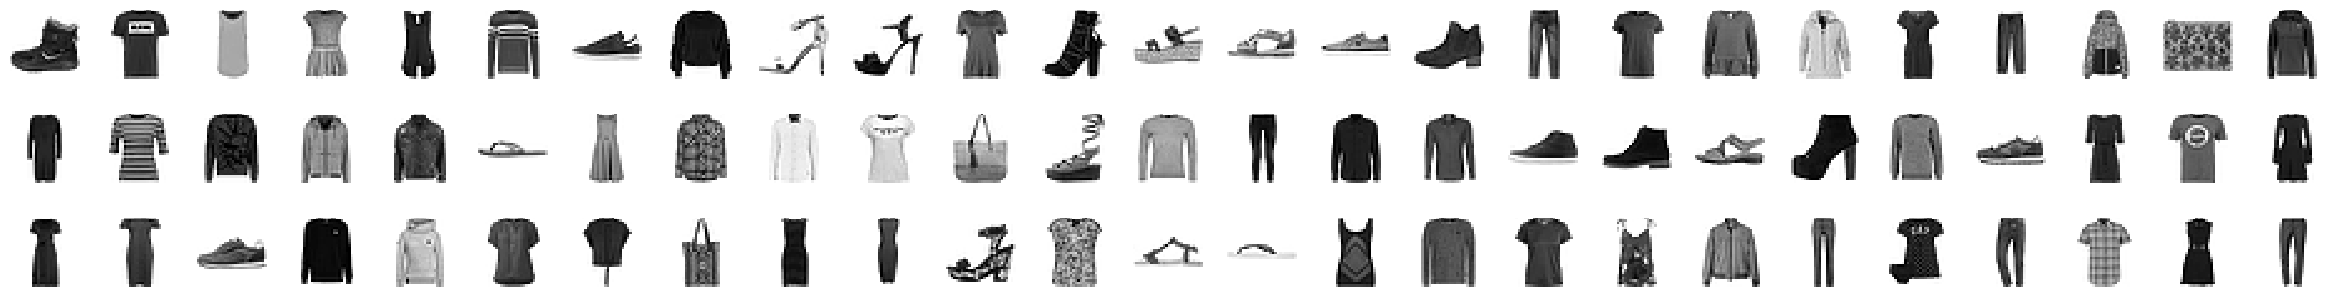

In [3]:
n_rows = 3
n_cols = 25
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
      index = n_cols * row + col
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
      plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#**Variational Autoencoder**


$$ \textbf{x} = \{x_1, x_2, \dots, x_n \} $$
$$ \textbf{z} \in \mathcal{R}^J $$
$$ \textbf{z} \sim \mathcal{n} (z_n|\mu, \sigma^2 ) $$

Task

- Compute the posterior distribution $p_{θ} (\textbf{z}_i|\textbf{x}_i)$
- Find the maximum likelihood estimates of $θ$

$$ p_{θ} (\textbf{z}_i | \textbf{x}_i) = \frac{p_{θ} (\textbf{z}_i | \textbf{x}_i) p (\textbf{z}_i) }{  \underbrace{\int p_{θ} (\textbf{x}_i | \textbf{z}_i ) p (\textbf{z}_i) d \textbf{z}_i }_{Marginalizing}} $$

"This marginalization requires solving an integral over all of the dimensions of the latent space"

$$ \begin{split}
  \hat{θ} & = \underset{θ}{argmax} \prod_{i=1}^n p_{θ} (\textbf{x}_i)
  \\
  & = \underset{θ}{argmax} \prod_{i=1}^n \int p_{θ} (\textbf{x}_i | \textbf{z}_i ) p (\textbf{z}_i) d \textbf{z}_i
\end{split} $$


$$ Q = \{ q_{i}(\textbf{z}_j): i= 1, 2, \dots, N \} $$

Variational inference uses the KL-divergence between $q_{i}(\textbf{z}_j)$ and $p_{θ}(\textbf{z}_i|\textbf{x}_i)$ as its measure of "closeness"

$$ \begin{split}
  ELBO(q) & = \underset{z_1, \dots, z_n \sim q}{E} \left[ \sum_{i=1}^{n} \log p_{θ} (\textbf{x}_i, \textbf{z}_i) - \sum_{i=1}^{n} \log q (\textbf{z}_i) \right]
  \\
  & = \sum_{i=1}^{n}\underset{z_i \sim q}{E} \left[ \log p_{θ} (\textbf{x}_i, \textbf{z}_i) - \log q (\textbf{z}_i) \right]
\end{split} $$

$$\hat{q} = \underset{q \in Q}{arg max} ELBO(q) $$


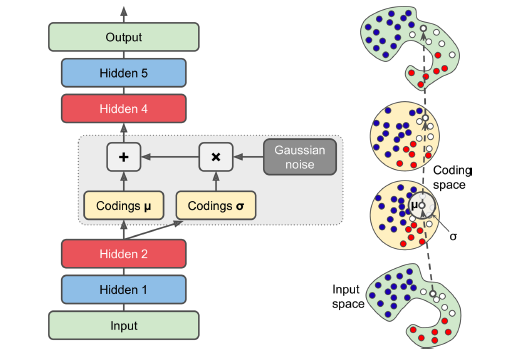

In [4]:
batch_size = 16
codings_size = 10

In [5]:
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

In [6]:
codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z)

In [7]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


In [8]:
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


In [9]:
decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [10]:
_, _, codings = variational_encoder(inputs)

reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [11]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [12]:
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=[X_valid, X_valid])

Epoch 1/50
430/430 [==============================] - 13s 6ms/step - loss: 0.4127 - val_loss: 0.3640
Epoch 2/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3543 - val_loss: 0.3492
Epoch 3/50
430/430 [==============================] - 3s 6ms/step - loss: 0.3436 - val_loss: 0.3419
Epoch 4/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3372 - val_loss: 0.3354
Epoch 5/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3328 - val_loss: 0.3333
Epoch 6/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3297 - val_loss: 0.3296
Epoch 7/50
430/430 [==============================] - 2s 6ms/step - loss: 0.3273 - val_loss: 0.3279
Epoch 8/50
430/430 [==============================] - 3s 6ms/step - loss: 0.3255 - val_loss: 0.3282
Epoch 9/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3241 - val_loss: 0.3263
Epoch 10/50
430/430 [==============================] - 2s 5ms/step - loss: 0.3229 - val_loss: 0.326

In [13]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

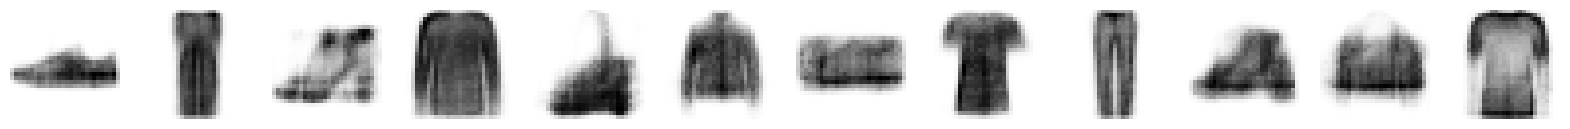

In [14]:
index = 1
plt.figure(figsize=(20, images.shape[0] * 1.8))
for i in range(images.shape[0]):
  plt.subplot(1, images.shape[0], index)
  plt.imshow(images[i,:,:], cmap="binary", interpolation="nearest")
  plt.axis('off')
  index += 1

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#**Variational Autoencoder CNN**

In [15]:
X_train = X_train.reshape(-1,28,28,1)
X_valid = X_valid.reshape(-1,28,28,1)
X_test  = X_test.reshape(-1,28,28,1)

X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

In [16]:
img_shape = (28, 28, 1) # For MNIST
latent_dim = 2          # Number of latent dimension parameters

**Encoder**

In [17]:
inputs = keras.layers.Input(shape=img_shape)

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = keras.layers.Dense(latent_dim)(x)
z_log_sigma = keras.layers.Dense(latent_dim)(x)


**Sampling function**

In [18]:
def sampling(args):
  z_mu, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
  return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

**Decoder**

In [19]:
# Decoder takes the latent distribution sample as input
decoder_input = keras.layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = keras.layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# Reshape
x = keras.layers.Reshape(shape_before_flattening[1:])(x)

# Use Conv2DTranspose to reverse the conv layers from the encoder
x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Decoder model statement
decoder = Model(decoder_input, x)

# Apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

**Loss**

In [20]:
# Construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # Reconstruction loss
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    # KL divergence
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

  # adds the custom loss to the class
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

# Apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [21]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_4[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
vae.fit(x=X_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(X_valid, None))